# -------------------------**Multiple Disease prediction**-------------------------------

### Liver Disease

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from xgboost import XGBClassifier

In [2]:
# Load dataset
df = pd.read_csv('indian_liver_patient.csv')

In [3]:
# EDA
print("Class distribution:\n", df['Dataset'].value_counts())
print("\nMissing values:\n", df.isnull().sum())
print("\nFeature summary:\n", df.describe())


Class distribution:
 Dataset
1    416
2    167
Name: count, dtype: int64

Missing values:
 Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

Feature summary:
               Age  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
count  583.000000       583.000000        583.000000            583.000000   
mean    44.746141         3.298799          1.486106            290.576329   
std     16.189833         6.209522          2.808498            242.937989   
min      4.000000         0.400000          0.100000             63.000000   
25%     33.000000         0.800000          0.200000            175.500000   
50%     45.000000         1.000000          0.300000     

In [4]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[col] = imputer.fit_transform(df[[col]])


In [5]:
# Encode categorical variables
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])

In [6]:
# Features & target prep
X = df.drop('Dataset', axis=1)
y = df['Dataset']
# Convert target to binary: patient (1) vs non-patient (2)
y = (y == 1).astype(int)


In [7]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
# Balance classes with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)


In [9]:
print("\nClass balance after SMOTE:\n", pd.Series(y_res).value_counts())


Class balance after SMOTE:
 Dataset
1    416
0    416
Name: count, dtype: int64


In [10]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)

In [11]:
# Models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [12]:
results = {}
conf_matrixes = {}
roc_curves = {}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train, cross-validate, and evaluate
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = model.decision_function(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    results[name] = {'cv_accuracy': scores.mean(), 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc_auc}
    conf_matrixes[name] = cm
    roc_curves[name] = (fpr, tpr)

C:\Users\DELL\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:40:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\DELL\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:40:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\DELL\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:40:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\DELL\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:40:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

In [13]:
# Metrics table
metrics_df = pd.DataFrame(results)
print("\nCross-validation & test metrics per model:\n", metrics_df)


Cross-validation & test metrics per model:
              LogisticRegression  DecisionTree  RandomForest   XGBoost
cv_accuracy            0.717293      0.724812      0.796992  0.781955
accuracy               0.760479      0.700599      0.802395  0.826347
precision              0.864407      0.681319      0.828947  0.837500
recall                 0.614458      0.746988      0.759036  0.807229
f1                     0.718310      0.712644      0.792453  0.822086
roc_auc                0.836059      0.700875      0.910714  0.912651


In [14]:
# Save metrics to CSV
metrics_df.to_csv('model_comparison_liver.csv')

In [15]:
# Select the best model by highest test accuracy
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name} with accuracy: {results[best_model_name]['accuracy']:.4f}")



Best model: XGBoost with accuracy: 0.8263


In [16]:
# Save the best model
with open('best_model_liver.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"\nBest model: {best_model_name} with accuracy: {results[best_model_name]['accuracy']:.4f}")


Best model: XGBoost with accuracy: 0.8263


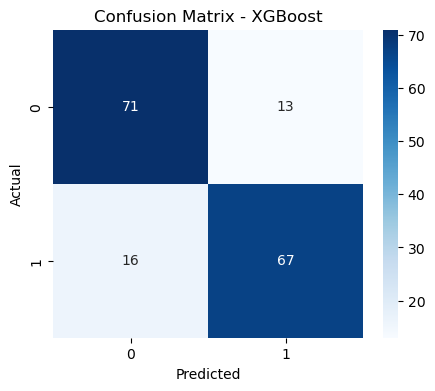

In [17]:
# Confusion Matrix for best model
best_cm = conf_matrixes[best_model_name]
plt.figure(figsize=(5,4))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

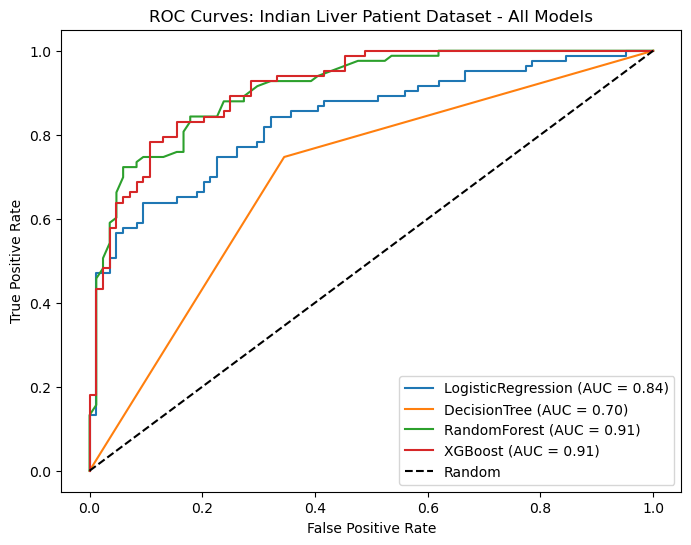

In [18]:
# ROC Curve for all models
plt.figure(figsize=(8,6))
for name in models.keys():
    fpr, tpr = roc_curves[name]
    auc = results[name]['roc_auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Indian Liver Patient Dataset - All Models')
plt.legend(loc='lower right')
plt.show()